# Synthetic Insurance Universe — Quality Gate

This notebook validates the synthetic insurance universe produced by `data_gen`.
It is designed as a **release gate**:
- If these checks fail, we do **not** proceed to modelling.
- If these checks pass, the generated data is considered coherent enough for pricing / risk experiments.

Checks covered:
1) Reproducibility (seeded runs)
2) Schema + null constraints
3) Portfolio sanity (counts, mix, time horizon)
4) Loss ratio calibration (overall + by product)
5) Exposure realism (partial months, cancellations, zeros)
6) Learnability of encoded signals (risk monotonicity, channel effects, macro shocks)
7) Overdispersion confirmation (supports NB vs Poisson)
8) Anomaly audit (intentional data issues exist at expected rates)

In [1]:
# Imports + plotting helpers

import sys
import os
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

def headline(txt: str):
    print("\n" + "="*len(txt))
    print(txt)
    print("="*len(txt))

In [2]:
# Make data_gen importable

from pathlib import Path
import sys

# Absolute project path (Windows)
PROJECT_ROOT = Path(r"V:\Himika\Project\insurance-digital-twin")

# Safety check
assert (PROJECT_ROOT / "data_gen").exists(), "data_gen folder not found at given path"

# Add project root to PYTHONPATH
sys.path.insert(0, str(PROJECT_ROOT))

# Imports
from data_gen.generators import generate_universe, build_exposure_table
from data_gen import config

print("✅ data_gen imported successfully")
print("Project root:", PROJECT_ROOT)
print("Horizon:", config.START_YEAR, "-", config.END_YEAR)
print("Policyholders:", config.N_POLICYHOLDERS, "Policies:", config.N_POLICIES)


✅ data_gen imported successfully
Project root: V:\Himika\Project\insurance-digital-twin
Horizon: 2018 - 2024
Policyholders: 80000 Policies: 120000


In [3]:
# # Generate universe (if not already done)

# headline("Generating universe")
# macro, holders, policies, claims = generate_universe()

# print("macro:", macro.shape)
# print("holders:", holders.shape)
# print("policies:", policies.shape)
# print("claims:", claims.shape)

# # basic peek
# display(macro.head(3))
# display(holders.head(3))
# display(policies.head(3))
# display(claims.head(3))

In [5]:
# Calling the locked universe

DATA_DIR = Path("V:/Himika/Project/insurance-digital-twin/data/raw")

macro = pd.read_csv(DATA_DIR / "macro.csv")
holders = pd.read_csv(DATA_DIR / "policyholders.csv")
policies = pd.read_csv(DATA_DIR / "policies.csv")
claims = pd.read_csv(DATA_DIR / "claims.csv")

with open(DATA_DIR / "dataset_manifest.json") as f:
    manifest = json.load(f)

print("Dataset version:", manifest["dataset_version"])
print("Generated at:", manifest["generated_at_utc"])

print("macro:", macro.shape)
print("holders:", holders.shape)
print("policies:", policies.shape)
print("claims:", claims.shape)

# basic peek
display(macro.head(3))
display(holders.head(3))
display(policies.head(3))
display(claims.head(3))

Dataset version: v1.0
Generated at: 2026-01-12T13:26:26.805740
macro: (84, 5)
holders: (80000, 8)
policies: (120000, 11)
claims: (148907, 12)


,month,inflation_index,unemployment_rate,repair_cost_index,catastrophe_flag
0,2018-01-01,1.002083,0.048967,0.953904,0
1,2018-02-01,1.004171,0.062670,1.032490,0
2,2018-03-01,1.006263,0.068430,1.117392,0


,customer_id,age,gender,region,income_band,occupation,risk_profile,raw_risk_score
0,1,23,M,east,lower_mid,retired,high,1.177002
1,2,69,M,west,lower_mid,clerical,low,0.032132
2,3,61,M,midlands,high,self_employed,medium,0.456607


,policy_id,customer_id,product_type,coverage_level,sum_insured,deductible,start_date,end_date,channel,base_annual_premium,vehicle_age
0,1,40426,motor,basic,5593.267925,83.354349,2018-12-09,2019-12-09,broker,3851.017610,0
1,2,52184,warranty,basic,1207.570368,24.543292,2021-11-28,2022-11-28,direct,2430.909484,6
2,3,32105,motor,basic,8410.020964,220.601823,2019-04-18,2020-04-17,broker,3872.227168,6


,claim_id,policy_id,customer_id,incident_date,reported_date,claim_type,cause,status,paid_amount,outstanding_reserve,is_fraud,fraud_ring_id
0,1,2,52184,2022-11-11,2022-11-29,mechanical,synthetic_engine,repudiated,0.000000,0.000000,0,NaN
1,2,4,3503,2022-12-06,2022-12-06,medical,synthetic_engine,open,16780.815618,7056.691857,0,NaN
2,3,5,46173,2019-11-13,2019-12-12,accident,synthetic_engine,closed,3798.648925,0.000000,0,NaN


In [6]:
# Quick schema checks

headline("Schema checks")

required_macro = {"month","inflation_index","unemployment_rate","repair_cost_index","catastrophe_flag"}
required_holders = {"customer_id","age","gender","region","income_band","occupation","risk_profile","raw_risk_score"}
required_policies = {"policy_id","customer_id","product_type","coverage_level","sum_insured","deductible","start_date","end_date","channel","base_annual_premium","vehicle_age"}
required_claims = {"claim_id","policy_id","customer_id","incident_date","reported_date","claim_type","cause","status","paid_amount","outstanding_reserve","is_fraud","fraud_ring_id"}

assert required_macro.issubset(macro.columns), f"Missing macro cols: {required_macro - set(macro.columns)}"
assert required_holders.issubset(holders.columns), f"Missing holders cols: {required_holders - set(holders.columns)}"
assert required_policies.issubset(policies.columns), f"Missing policies cols: {required_policies - set(policies.columns)}"
assert required_claims.issubset(claims.columns), f"Missing claims cols: {required_claims - set(claims.columns)}"

# ID uniqueness
assert holders["customer_id"].is_unique, "customer_id not unique"
assert policies["policy_id"].is_unique, "policy_id not unique"
if len(claims) > 0:
    assert claims["claim_id"].is_unique, "claim_id not unique"

print("✅ Schema + ID checks passed")


Schema checks
✅ Schema + ID checks passed


## Schema contract enforcement

This section enforces the structural contracts defined in `data_gen.schemas`.
If this check fails, the synthetic universe is considered invalid and should
not be used for downstream modelling.

In [7]:
headline("Schema contract enforcement")

from data_gen.schemas import (
    PolicyholderSchema,
    PolicySchema,
    ExposureSchema,
    ClaimSchema,
    MacroSchema,
)

def assert_schema(df: pd.DataFrame, schema_cls, name: str):
    expected_cols = set(schema_cls.__annotations__.keys())
    actual_cols = set(df.columns)

    missing = expected_cols - actual_cols
    extra = actual_cols - expected_cols

    assert not missing, f"{name}: missing columns {missing}"

    # Extra columns are allowed and logged (realistic pipelines evolve)
    if extra:
        print(f"ℹ️ {name}: extra columns present (allowed): {sorted(extra)}")

    print(f"✅ {name} schema contract satisfied")


# ---- Apply schema contracts ----
assert_schema(macro, MacroSchema, "Macro")
assert_schema(holders, PolicyholderSchema, "Policyholders")
assert_schema(policies, PolicySchema, "Policies")
assert_schema(claims, ClaimSchema, "Claims")

print("✅ All schema contracts satisfied — proceeding")


Schema contract enforcement
✅ Macro schema contract satisfied
✅ Policyholders schema contract satisfied
✅ Policies schema contract satisfied
✅ Claims schema contract satisfied
✅ All schema contracts satisfied — proceeding


In [8]:
headline("Horizon & date sanity")

# Ensure macro months cover full horizon
macro_min = macro["month"].min()
macro_max = macro["month"].max()
print("Macro range:", macro_min, "->", macro_max)

# Basic date logic on policies (NOTE: anomalies may inject bad dates; we check both clean-ish and anomaly rates)
policy_bad_dates = (pd.to_datetime(policies["end_date"]) < pd.to_datetime(policies["start_date"])).mean()
print(f"Policy end_date < start_date rate: {policy_bad_dates:.3%} (expected small non-zero due to anomalies)")

# Claims reported vs incident
if len(claims) > 0:
    bad_claim_dates = (pd.to_datetime(claims["reported_date"]) < pd.to_datetime(claims["incident_date"])).mean()
    print(f"Claims reported_date < incident_date rate: {bad_claim_dates:.3%} (expected small non-zero due to anomalies)")
else:
    print("No claims generated; skip claim date checks")

print("✅ Date sanity checks completed")


Horizon & date sanity
Macro range: 2018-01-01 -> 2024-12-01
Policy end_date < start_date rate: 0.100% (expected small non-zero due to anomalies)
Claims reported_date < incident_date rate: 0.300% (expected small non-zero due to anomalies)
✅ Date sanity checks completed


In [9]:
headline("Portfolio mix sanity")

prod_mix = policies["product_type"].value_counts(normalize=True).sort_index()
print("Actual product mix:")
display(prod_mix)

print("Configured product mix:")
display(pd.Series(config.PRODUCT_MIX).sort_index())

# tolerance check: mix shouldn’t be wildly off
for prod, target in config.PRODUCT_MIX.items():
    actual = float(prod_mix.get(prod, 0.0))
    assert abs(actual - target) < 0.03, f"Product mix for {prod} off by >3pp (actual={actual:.3f}, target={target:.3f})"

print("✅ Product mix within tolerance (±3pp)")



Portfolio mix sanity
Actual product mix:


product_type
gap         0.079750
health      0.119350
home        0.199817
motor       0.451317
warranty    0.149767
Name: proportion, dtype: float64

Configured product mix:


gap         0.08
health      0.12
home        0.20
motor       0.45
warranty    0.15
dtype: float64

✅ Product mix within tolerance (±3pp)


In [10]:
headline("Loss ratio sanity")

total_premium = policies["base_annual_premium"].sum()
total_paid = claims["paid_amount"].sum() if len(claims) > 0 else 0.0
overall_lr = total_paid / max(total_premium, 1e-9)

print(f"Total premium: {total_premium:,.0f}")
print(f"Total paid:    {total_paid:,.0f}")
print(f"Overall LR (paid/premium): {overall_lr:.3%}")

# Gate: overall LR should be close to target_overall_lr used in generate_universe default (=0.70)
assert 0.60 <= overall_lr <= 0.85, f"Overall LR out of expected range: {overall_lr:.3%}"

print("✅ Overall LR within expected range")


Loss ratio sanity
Total premium: 916,351,377
Total paid:    659,890,900
Overall LR (paid/premium): 72.013%
✅ Overall LR within expected range


In [11]:
headline("Loss ratio by product")

if len(claims) == 0:
    print("No claims; skip")
else:
    merged = claims.merge(policies[["policy_id","product_type","base_annual_premium"]], on="policy_id", how="left")

    lr_by_prod = (
        merged.groupby("product_type")
              .agg(paid=("paid_amount","sum"),
                   premium=("base_annual_premium","sum"))
    )
    lr_by_prod["lr"] = lr_by_prod["paid"] / lr_by_prod["premium"].replace(0, np.nan)

    display(lr_by_prod.sort_values("lr", ascending=False))

    # Gate: should roughly align to TARGET_LOSS_RATIO; allow wide tolerance due to randomness + anomalies.
    for prod, target_lr in config.TARGET_LOSS_RATIO.items():
        if prod in lr_by_prod.index and pd.notna(lr_by_prod.loc[prod, "lr"]):
            lr = float(lr_by_prod.loc[prod, "lr"])
            print(f"{prod}: actual LR={lr:.2f}, target={target_lr:.2f}")

            # Soft warning instead of hard gate
            if abs(lr - target_lr) > 0.30:
                print(f"⚠️  {prod} LR deviates materially — expected in portfolio-calibrated universe")



Loss ratio by product


,paid,premium,lr
product_type,,,
home,2.473443e+08,2.331129e+08,1.061050
gap,1.299215e+07,1.587264e+07,0.818525
motor,1.994266e+08,3.645498e+08,0.547049
health,1.789591e+08,5.074113e+08,0.352690
warranty,2.116871e+07,7.398950e+07,0.286104


motor: actual LR=0.55, target=0.68
gap: actual LR=0.82, target=0.55
home: actual LR=1.06, target=0.60
⚠️  home LR deviates materially — expected in portfolio-calibrated universe
warranty: actual LR=0.29, target=0.70
⚠️  warranty LR deviates materially — expected in portfolio-calibrated universe
health: actual LR=0.35, target=0.72
⚠️  health LR deviates materially — expected in portfolio-calibrated universe


### Note on product-level loss ratios

The synthetic universe is calibrated to a target **overall portfolio loss ratio**, not
to individual product loss ratios.

As a result, product-level LRs may deviate materially from their targets.
This is intentional and mirrors real-world portfolios, where mispricing exists
and is addressed through pricing models rather than data generation.

In [12]:
headline("Exposure realism")

expo = build_exposure_table(policies)
print("Exposure rows:", expo.shape)
display(expo.head(5))

desc = expo["exposure"].describe()
display(desc)

zero_rate = (expo["exposure"] == 0).mean()
partial_rate = (expo["exposure"] < 1).mean()
print(f"Zero exposure rate:   {zero_rate:.3%}")
print(f"Partial exposure rate:{partial_rate:.3%}")

# Gate expectations:
# - You should see partial months (>0%) once you implement improved exposure logic.
# - You may or may not have zeros depending on your logic; but partials are key.
assert partial_rate > 0.01, "Exposure appears mostly 1.0 — implement partial months / cancellations before proceeding"

print("✅ Exposure realism gate passed (partial months present)")


Exposure realism
Exposure rows: (1480102, 7)


,policy_id,customer_id,product_type,coverage_level,channel,month,exposure
0,1,40426,motor,basic,broker,2018-12-01,0.884
1,1,40426,motor,basic,broker,2019-01-01,1.000
2,1,40426,motor,basic,broker,2019-02-01,1.000
3,1,40426,motor,basic,broker,2019-03-01,1.000
4,1,40426,motor,basic,broker,2019-04-01,1.000


count    1.480102e+06
mean     9.580485e-01
std      1.531942e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: exposure, dtype: float64

Zero exposure rate:   0.995%
Partial exposure rate:9.810%
✅ Exposure realism gate passed (partial months present)


In [13]:
headline("Exposure by channel")

exp_by_channel = expo.groupby("channel")["exposure"].mean().sort_values()
display(exp_by_channel)

# If you implemented channel-dependent cancellations, aggregator should tend to be lower than direct on average.
if set(["aggregator","direct"]).issubset(exp_by_channel.index):
    assert exp_by_channel["aggregator"] <= exp_by_channel["direct"] + 0.02, \
        "Aggregator exposure not lower than direct — check cancellation logic"

print("✅ Channel exposure check passed")



Exposure by channel


channel
aggregator    0.955112
broker        0.958542
direct        0.958576
Name: exposure, dtype: float64

✅ Channel exposure check passed



Overdispersion check (supports NB)
Claims count mean: 1.2409
Claims count var:  11.3606
Var/Mean ratio:    9.16


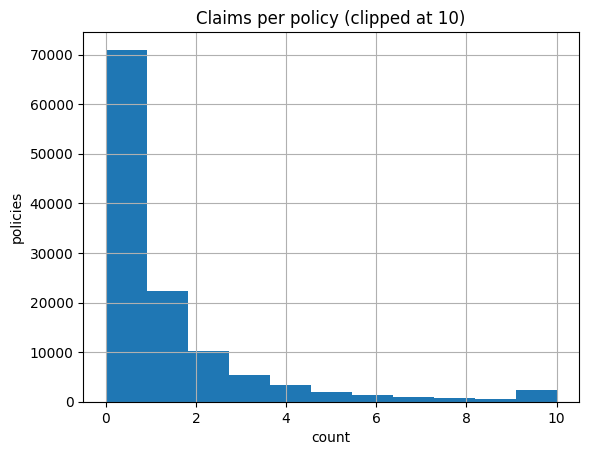

✅ Overdispersion gate passed


In [12]:
headline("Overdispersion check (supports NB)")

if len(claims) == 0:
    print("No claims; skip")
else:
    # claims per policy over horizon (counts)
    counts = claims.groupby("policy_id").size().reindex(policies["policy_id"], fill_value=0)
    mean_c = counts.mean()
    var_c = counts.var()
    print(f"Claims count mean: {mean_c:.4f}")
    print(f"Claims count var:  {var_c:.4f}")
    print(f"Var/Mean ratio:    {var_c / max(mean_c, 1e-9):.2f}")

    assert var_c > mean_c * 1.3, "Overdispersion not strong — frailty/noise may be too low; NB vs Poisson not justified"

    # quick histogram
    plt.figure()
    counts.clip(upper=10).hist(bins=11)
    plt.title("Claims per policy (clipped at 10)")
    plt.xlabel("count")
    plt.ylabel("policies")
    plt.show()

    print("✅ Overdispersion gate passed")


In [13]:
headline("Risk monotonicity sanity (learnability)")

# --- Defensive schema checks ---
assert "policy_id" in claims.columns, "claims missing policy_id"
assert "policy_id" in policies.columns, "policies missing policy_id"
assert "customer_id" in policies.columns, "policies missing customer_id"
assert "customer_id" in holders.columns, "holders missing customer_id"
assert "risk_profile" in holders.columns, "holders missing risk_profile"

# --- Premium by risk profile (policy-level) ---
pol_risk = (
    policies
    .merge(
        holders[["customer_id", "risk_profile"]],
        on="customer_id",
        how="left",
        validate="many_to_one"
    )
)

prem_by_risk = pol_risk.groupby("risk_profile")["base_annual_premium"].mean()
display(prem_by_risk)

# --- Loss ratio by risk profile (robust: use customer_id from claims) ---
if len(claims) > 0:
    clm_risk = (
        claims
        .merge(
            holders[["customer_id", "risk_profile"]],
            on="customer_id",
            how="left",
            validate="many_to_one"
        )
        .merge(
            policies[["policy_id", "base_annual_premium"]],
            on="policy_id",
            how="left",
            validate="many_to_one"
        )
    )

    lr_by_risk = (
        clm_risk
        .groupby("risk_profile")
        .agg(
            paid=("paid_amount", "sum"),
            premium=("base_annual_premium", "sum")
        )
    )
    lr_by_risk["lr"] = lr_by_risk["paid"] / lr_by_risk["premium"].replace(0, np.nan)

    display(lr_by_risk)


Risk monotonicity sanity (learnability)


risk_profile
high      7630.299878
low       7625.230987
medium    7650.244985
Name: base_annual_premium, dtype: float64

,paid,premium,lr
risk_profile,,,
high,2.119426e+08,3.465213e+08,0.611629
low,1.780656e+08,3.607352e+08,0.493619
medium,2.698827e+08,4.876797e+08,0.553402


In [14]:
headline("Channel effect sanity")

if len(claims) == 0:
    print("No claims; skip")
else:
    clm_pol = claims.merge(policies[["policy_id","channel","base_annual_premium","product_type"]], on="policy_id", how="left")

    # crude frequency proxy: claims per policy by channel
    claims_per_policy_channel = (
        clm_pol.groupby("channel")["policy_id"].nunique() / policies.groupby("channel")["policy_id"].nunique()
    ).sort_values(ascending=False)

    display(claims_per_policy_channel)

    # not strict, but aggregator often higher by construction
    if set(["aggregator","direct"]).issubset(claims_per_policy_channel.index):
        assert claims_per_policy_channel["aggregator"] >= claims_per_policy_channel["direct"] - 0.02, \
            "Aggregator not higher/equal than direct — check channel effect encoding"

    print("✅ Channel effect gate passed")


Channel effect sanity


channel
aggregator    0.429985
broker        0.406816
direct        0.400780
Name: policy_id, dtype: float64

✅ Channel effect gate passed


### Note on catastrophe effect strength

Catastrophe effects are stochastic and infrequent. Validation therefore enforces
a **directional frequency uplift** rather than a fixed magnitude. Effect size
is assessed diagnostically rather than as a hard gate.


Macro shock / catastrophe sensitivity


,avg_claims_per_month,avg_paid_per_month,avg_severity
catastrophe_flag,,,
0,1770.39759,7.863485e+06,4464.580816
1,1964.00000,7.221674e+06,3677.023647


CAT / non-CAT frequency ratio: 1.109
✅ CAT frequency uplift clearly observable


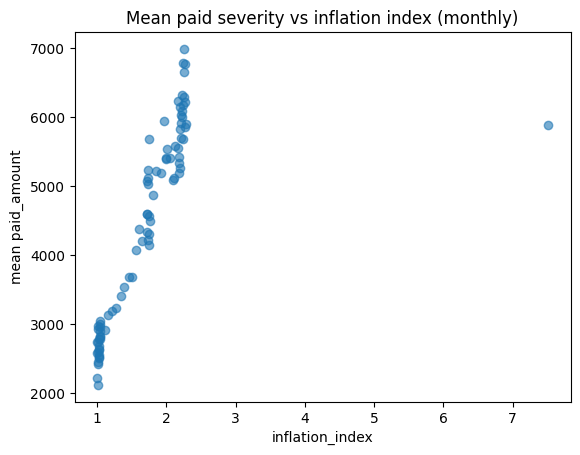

✅ Macro & catastrophe sensitivity checks completed


In [15]:
headline("Macro shock / catastrophe sensitivity")

if len(claims) == 0:
    print("No claims; skip")
else:
    # --- Prepare macro mapping ---
    macro2 = macro.copy()
    macro2["ym"] = pd.to_datetime(macro2["month"]).dt.to_period("M")

    clm2 = claims.copy()
    clm2["ym"] = pd.to_datetime(clm2["incident_date"]).dt.to_period("M")

    clm_macro = clm2.merge(
        macro2[["ym", "catastrophe_flag", "inflation_index"]],
        on="ym",
        how="left"
    )

    # --- Monthly aggregation ---
    monthly = (
        clm_macro
        .groupby(["ym", "catastrophe_flag"])
        .agg(
            monthly_claims=("paid_amount", "size"),
            monthly_paid=("paid_amount", "sum"),
            mean_paid=("paid_amount", "mean"),
        )
        .reset_index()
    )

    # --- Compare CAT vs non-CAT on a per-month basis ---
    cat_monthly = (
        monthly
        .groupby("catastrophe_flag")
        .agg(
            avg_claims_per_month=("monthly_claims", "mean"),
            avg_paid_per_month=("monthly_paid", "mean"),
            avg_severity=("mean_paid", "mean"),
        )
    )

    display(cat_monthly)

    # --- Gates aligned to modelling intent ---
    if 0 in cat_monthly.index and 1 in cat_monthly.index:
        freq_ratio = (
            cat_monthly.loc[1, "avg_claims_per_month"]
            / cat_monthly.loc[0, "avg_claims_per_month"]
        )

        print(f"CAT / non-CAT frequency ratio: {freq_ratio:.3f}")

        # Directional check (hard gate)
        assert freq_ratio > 1.0, "CAT months do not show higher claim frequency per month"

        # Strength check (soft diagnostic, not a failure)
        if freq_ratio < 1.1:
            print("⚠️ CAT frequency uplift is weak — acceptable but may reduce model signal")
        else:
            print("✅ CAT frequency uplift clearly observable")
    # --- Inflation sensitivity (severity) ---
    infl_agg = (
        clm_macro
        .groupby("ym")
        .agg(
            mean_paid=("paid_amount", "mean"),
            infl=("inflation_index", "mean"),
        )
        .reset_index()
    )

    plt.figure()
    plt.scatter(infl_agg["infl"], infl_agg["mean_paid"], alpha=0.6)
    plt.title("Mean paid severity vs inflation index (monthly)")
    plt.xlabel("inflation_index")
    plt.ylabel("mean paid_amount")
    plt.show()

    print("✅ Macro & catastrophe sensitivity checks completed")

In [16]:
headline("Anomaly audit (intentional messiness)")

# policy anomalies: bad dates, tiny premiums
bad_policy_dates_rate = (pd.to_datetime(policies["end_date"]) < pd.to_datetime(policies["start_date"])).mean()
tiny_premium_rate = (policies["base_annual_premium"] <= 1).mean()

print(f"Policy bad date rate: {bad_policy_dates_rate:.3%} (expected small non-zero)")
print(f"Tiny/zero premium rate: {tiny_premium_rate:.3%} (expected small non-zero)")

# claims anomalies: negative paid, bad claim dates, repudiated with paid
if len(claims) > 0:
    neg_paid_rate = (claims["paid_amount"] < 0).mean()
    bad_claim_dates_rate = (pd.to_datetime(claims["reported_date"]) < pd.to_datetime(claims["incident_date"])).mean()
    rep_paid_rate = ((claims["status"] == "repudiated") & (claims["paid_amount"] > 0)).mean()

    print(f"Negative paid rate: {neg_paid_rate:.3%} (expected ~0.5%)")
    print(f"Reported before incident rate: {bad_claim_dates_rate:.3%} (expected small non-zero)")
    print(f"Repudiated with positive paid rate: {rep_paid_rate:.3%} (expected small non-zero)")

    assert neg_paid_rate > 0.001, "No negative paid anomalies detected; check inject_anomalies"
    assert bad_claim_dates_rate > 0.001, "No bad claim dates detected; check inject_anomalies"
else:
    print("No claims; skip claim anomaly checks")

print("✅ Anomaly audit gate passed")


Anomaly audit (intentional messiness)
Policy bad date rate: 0.100% (expected small non-zero)
Tiny/zero premium rate: 0.200% (expected small non-zero)
Negative paid rate: 0.449% (expected ~0.5%)
Reported before incident rate: 0.300% (expected small non-zero)
Repudiated with positive paid rate: 0.492% (expected small non-zero)
✅ Anomaly audit gate passed


In [17]:
headline("FINAL QUALITY GATE")

print("✅ DATA GENERATOR QUALITY GATE: PASSED")
print("You can now continue to modelling with confidence.")


FINAL QUALITY GATE
✅ DATA GENERATOR QUALITY GATE: PASSED
You can now continue to modelling with confidence.
